### Theoretical limit

In [20]:
def theory_limit(n):
    return 1/4*(4**n-3*n-1)
def qsd_limit(n):
    return 23/48*(4**n)-3/2*(2**n)+4/3
qsd_limit(4)

100.0

### Cost function

In [21]:
import numpy as np
import scipy
def c_hst(U,V):
    d = U.shape[0]
    return 1 - 1/(d**2)*(np.abs(np.trace(np.conjugate(np.transpose(V))@U)))**2
def f_hat(U,V):
    d = U.shape[0]
    return 1 - d/(d + 1) * c_hst(U,V)
def frobenius(U,V):
    return 1/2*np.linalg.norm(V - U,'fro')
def frobenius_fidelity(U,V):
    d = U.shape[0]
    return 1 - d/(d + 1) + 1/(d*(d+1))*(d - frobenius(U,V))**2

u = np.random.rand(8, 8)
q, r = np.linalg.qr(u)
import time
start = time.time()
(frobenius_fidelity(q,q))
end = time.time()
print(end - start)

3.719329833984375e-05


### Circuit

In [50]:
import qiskit
from qiskit.quantum_info import Operator

def mcx_gate(num_qubits):
    mcx_gate = qiskit.circuit.library.MCXGate(num_qubits - 1)
    return np.real(Operator(mcx_gate).data)

def U3cry(num_qubits: int, num_layers: int, thetas: qiskit.circuit.ParameterVector, active_blocks: np.ndarray) -> tuple[qiskit.QuantumCircuit, np.ndarray]:
    qc = qiskit.QuantumCircuit(num_qubits)
    k = 0
    index_params = 0
    for _ in range(num_layers):
        for i in range(num_qubits):
            for j in range(i + 1, num_qubits):
                if active_blocks[k] == 1:
                    qc.u(thetas[index_params],thetas[index_params + 1],thetas[index_params + 2],i)
                    qc.u(thetas[index_params],thetas[index_params + 1],thetas[index_params + 2],j)
                    qc.cry(thetas[index_params], j, i)
                    index_params += 7
                k += 1
                qc.barrier()
    return qc, qiskit.quantum_info.Operator(qc).data # .draw('mpl')

In [52]:
import qiskit
import qiskit.quantum_info
from qoop.core.optimizer import adam
%load_ext autoreload
%autoreload 2
import constant
def num_params_on_active_gates(active_gates):
    num_params = 0
    for i in range(0, len(active_gates), 3):
        num_params += (active_gates[i] + active_gates[i+1]) * 3
        num_params += active_gates[i + 2] * 1
    return int(num_params)

def num_params_on_active_blocks(active_blocks):
    num_params = 0
    for _ in range(0, len(active_blocks)):
        num_params += 7
    return int(num_params)

def target_func(num_qubits, num_layers, active_blocks):
    
    thetas = np.ones(num_params_on_active_blocks(active_blocks))
    costs, thetass = [], []
    def objective(thetas):
        _, U = U3cry(num_qubits, num_layers, thetas, active_blocks)
        return c_hst(U, mcx_gate(num_qubits))
    for iter in range(constant.num_iterations):
        cost = objective(thetas)
        costs.append(cost)
        if cost < constant.error:
            print('Converged')
            break
        thetass.append(thetas)
        grad = np.zeros(len(thetas))
        for j in range(0, len(thetas)):
            thetas_plus = thetas.copy()
            thetas_plus[j] += constant.shift
            thetas_minus = thetas.copy()
            thetas_minus[j] -= constant.shift
            grad[j] = (objective(thetas_plus) - objective(thetas_minus))/(2*constant.shift)
        if iter == 0:
            m, v1 = list(np.zeros(thetas.shape[0])), list(
                np.zeros(thetas.shape[0]))
        thetas = adam(thetas, m, v1, iter, grad)
    return costs, thetass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
num_qubits = 3
num_layers = 3
active_blocks = np.ones((num_qubits*(num_qubits-1)//2) * num_layers) # num_blocks = num_qubits*(num_qubits-1)//2
active_blocks[2] = 0
costs, _ = target_func(num_qubits, num_layers, active_blocks)
print(costs[-1])

0.282163461463769


0.282163461463769


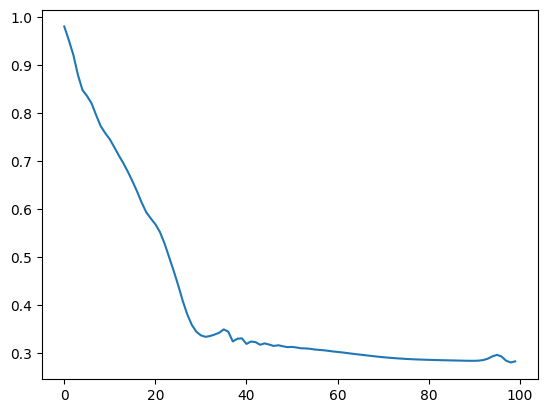

In [54]:
import matplotlib.pyplot as plt
print(costs[-1])
plt.plot(costs)

18
40


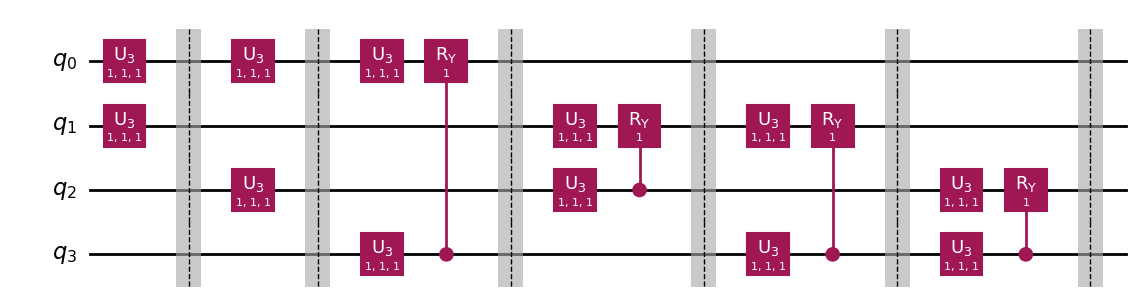

In [26]:
import qiskit
num_qubits = 4
num_layers = 1
num_blocks = num_qubits*(num_qubits-1)//2
active_gates = np.ones(3*num_blocks*num_layers)
active_gates[2] = 0
active_gates[5] = 0
thetas = np.ones(num_params_on_active_gates(active_gates))
print(len(active_gates))
print(len(thetas))
qc_x, _ = U3cry(num_qubits, num_layers, thetas, active_gates)
qc_excipilit = qiskit.transpile(qc_x, basis_gates=['u3','cry'], optimization_level=1)
qc_excipilit.draw('mpl')

In [66]:
num_qubits = 3
num_layers = 3
active_blocks = np.ones((num_qubits*(num_qubits-1)//2) * num_layers) # num_blocks = num_qubits*(num_qubits-1)//2
def check(xs):
    costs, _ = target_func(num_qubits, num_layers, active_blocks)
    if costs[-1] < constant.error:
        return True
    return False
    # return xs[2] == 0 and xs[5] == 1
for i in range(len(active_blocks)):
    for j in range(len(active_blocks)):
        if active_blocks[j] == 1:
            active_blocks[j] = 0
            print(check(active_blocks))
            print(active_blocks)
            if check(active_blocks) == False:
                active_blocks[j] = 1
            
print(active_blocks)

False
[0. 1. 1. 1. 1. 1. 1. 1. 1.]
False
[1. 0. 1. 1. 1. 1. 1. 1. 1.]
True
[1. 1. 0. 1. 1. 1. 1. 1. 1.]
True
[1. 1. 0. 0. 1. 1. 1. 1. 1.]
True
[1. 1. 0. 0. 0. 1. 1. 1. 1.]
False
[1. 1. 0. 0. 0. 0. 1. 1. 1.]
True
[1. 1. 0. 0. 0. 1. 0. 1. 1.]
True
[1. 1. 0. 0. 0. 1. 0. 0. 1.]
True
[1. 1. 0. 0. 0. 1. 0. 0. 0.]
True
[0. 1. 0. 0. 0. 1. 0. 0. 0.]
True
[0. 0. 0. 0. 0. 1. 0. 0. 0.]
False
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
False
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
False
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
False
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
False
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
False
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
False
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
False
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0.]
